## competition link
 https://www.kaggle.com/competitions/nlp-getting-started

In [44]:
import nltk
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import string
from tqdm import tqdm
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from keras.initializers import Constant
from keras.optimizers import Adam
import tensorflow as tf
import nltk

In [45]:
nltk.download('stopwords')
stop = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/sheded/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [46]:
stop

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [47]:
train = pd.read_csv('data/DiseasterTweets/train.csv')
test = pd.read_csv('data/DiseasterTweets/test.csv')

In [48]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [49]:
train.shape

(7613, 5)

/home/sheded/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


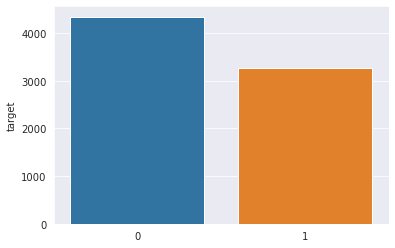

In [50]:
class_dist = train['target'].value_counts()
sns.barplot(class_dist.index, class_dist)
plt.show()

/home/sheded/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


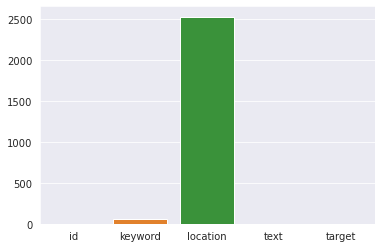

In [51]:
nulls = train.isnull().sum()
sns.barplot(nulls.index, nulls)
plt.show()

In [52]:
def remove_spec(text):
    text = re.sub('<.*?>+', '', text)
    text = text.lower()
    return text

def remove_punctuation(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

def remove_urls(text):
    text = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+",'',text)
    return text

def remove_emoji(text):
    emojis = re.compile("["
                        u"\U0001F600-\U0001F64F"  # emoticons
                        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                        u"\U0001F680-\U0001F6FF"  # transport & map symbols
                        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                        u"\U00002702-\U000027B0"
                        u"\U000024C2-\U0001F251"
                        "]+", flags=re.UNICODE)
    text = re.sub(emojis, '', text)
    return text

In [53]:
train['cleand_text'] = train['text'].apply(lambda x: remove_punctuation(x))
train['cleand_text'] = train['cleand_text'].apply(lambda x: remove_urls(x))
train['cleand_text'] = train['cleand_text'].apply(lambda x: remove_emoji(x))
train['cleand_text'] = train['cleand_text'].apply(lambda x: remove_spec(x))

In [65]:
# creatingwords corpus
def create_corpus(dataset):
    corpus=[]
    for review in tqdm(dataset['cleand_text']):
        words = [word.lower() for word in word_tokenize(review) if (word.isalpha() == 1) & (word not in stop)]
        corpus.append(words)
    return corpus
corpus = create_corpus(train)

100%|██████████| 7613/7613 [00:01<00:00, 5152.13it/s]


In [66]:
corpus

[['deeds', 'reason', 'earthquake', 'may', 'allah', 'forgive', 'us'],
 ['forest', 'fire', 'near', 'la', 'ronge', 'sask', 'canada'],
 ['residents',
  'asked',
  'shelter',
  'place',
  'notified',
  'officers',
  'evacuation',
  'shelter',
  'place',
  'orders',
  'expected'],
 ['people', 'receive', 'wildfires', 'evacuation', 'orders', 'california'],
 ['got',
  'sent',
  'photo',
  'ruby',
  'alaska',
  'smoke',
  'wildfires',
  'pours',
  'school'],
 ['rockyfire',
  'update',
  'california',
  'hwy',
  'closed',
  'directions',
  'due',
  'lake',
  'county',
  'fire',
  'cafire',
  'wildfires'],
 ['flood',
  'disaster',
  'heavy',
  'rain',
  'causes',
  'flash',
  'flooding',
  'streets',
  'manitou',
  'colorado',
  'springs',
  'areas'],
 ['im', 'top', 'hill', 'see', 'fire', 'woods'],
 ['theres',
  'emergency',
  'evacuation',
  'happening',
  'building',
  'across',
  'street'],
 ['im', 'afraid', 'tornado', 'coming', 'area'],
 ['three', 'people', 'died', 'heat', 'wave', 'far'],
 ['h

In [67]:
max_len = 20
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
sequences = tokenizer.texts_to_sequences(corpus)
corpus_pad = pad_sequences(sequences, maxlen=max_len, truncating='post', padding='post')

In [69]:
corpus_pad

array([[4162,  691,  145, ...,    0,    0,    0],
       [  96,    4,  127, ...,    0,    0,    0],
       [1517, 1400, 1890, ...,    0,    0,    0],
       ...,
       [ 469, 1388,    0, ...,    0,    0,    0],
       [  16,  957, 2891, ...,    0,    0,    0],
       [ 111,  107,  415, ...,    0,    0,    0]], dtype=int32)

In [71]:
word_index = tokenizer.word_index
num_words = len(word_index)+1

In [80]:
model = Sequential()
model.add(Embedding(num_words, 100, input_length=max_len))
model.add(SpatialDropout1D(0.5))
model.add(LSTM(64, dropout=0.3, recurrent_dropout=0.35))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 20, 100)           1688400   
                                                                 
 spatial_dropout1d_2 (Spatia  (None, 20, 100)          0         
 lDropout1D)                                                     
                                                                 
 lstm_2 (LSTM)               (None, 64)                42240     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,730,705
Trainable params: 1,730,705
Non-trainable params: 0
_________________________________________________________________


In [81]:
X_train, X_test, y_train, y_test = train_test_split(corpus_pad, train['target'].values, test_size=0.25, random_state=2222)
print('X train shape ',X_train.shape)
print('X test shape ', X_test.shape)
print('y train shape ', y_train.shape)
print('y test shape ', y_test.shape)

X train shape  (5709, 20)
X test shape  (1904, 20)
y train shape  (5709,)
y test shape  (1904,)


In [82]:
history = model.fit(X_train, y_train, batch_size=32, epochs=30, validation_data=(X_test, y_test), verbose=2)

Epoch 1/30
179/179 - 14s - loss: 0.5881 - accuracy: 0.6807 - val_loss: 0.4406 - val_accuracy: 0.8004 - 14s/epoch - 79ms/step
Epoch 2/30
179/179 - 10s - loss: 0.3623 - accuracy: 0.8551 - val_loss: 0.4382 - val_accuracy: 0.8051 - 10s/epoch - 55ms/step
Epoch 3/30
179/179 - 12s - loss: 0.2503 - accuracy: 0.9066 - val_loss: 0.5301 - val_accuracy: 0.7857 - 12s/epoch - 68ms/step
Epoch 4/30
179/179 - 10s - loss: 0.1794 - accuracy: 0.9350 - val_loss: 0.5069 - val_accuracy: 0.7815 - 10s/epoch - 56ms/step
Epoch 5/30
179/179 - 10s - loss: 0.1308 - accuracy: 0.9534 - val_loss: 0.5228 - val_accuracy: 0.7752 - 10s/epoch - 56ms/step
Epoch 6/30
179/179 - 10s - loss: 0.1076 - accuracy: 0.9657 - val_loss: 0.6609 - val_accuracy: 0.7747 - 10s/epoch - 55ms/step
Epoch 7/30
179/179 - 10s - loss: 0.0932 - accuracy: 0.9693 - val_loss: 0.6280 - val_accuracy: 0.7710 - 10s/epoch - 58ms/step
Epoch 8/30
179/179 - 10s - loss: 0.0721 - accuracy: 0.9751 - val_loss: 0.7256 - val_accuracy: 0.7621 - 10s/epoch - 54ms/step


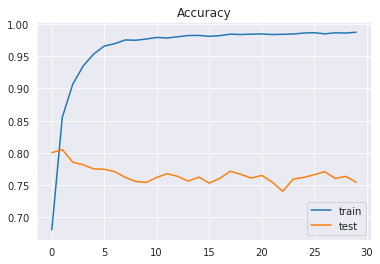

In [83]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [84]:
test['cleand_text'] = test['text'].apply(lambda x : remove_punctuation(x))
test['cleand_text'] = test['cleand_text'].apply(lambda x : remove_urls(x))
test['cleand_text'] = test['cleand_text'].apply(lambda x : remove_emoji(x))
test['cleand_text'] = test['cleand_text'].apply(lambda x : remove_spec(x))

In [85]:
test_corpus = create_corpus(test)

100%|██████████| 3263/3263 [00:00<00:00, 5060.44it/s]


In [86]:
test_sequences = tokenizer.texts_to_sequences(test_corpus)

test_corpus_pad = pad_sequences(test_sequences, maxlen=max_len, truncating='post', padding='post')

In [87]:
predictions = model.predict(test_corpus_pad)
predictions = np.round(predictions).astype(int).reshape(3263)

102/102 [==============================] - 1s 7ms/step


In [88]:
submission = pd.DataFrame({'id' : test['id'], 'target' : predictions})
submission.to_csv('final_submission.csv', index=False)

submission.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
